In [18]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import ndimage
os.name

'nt'

In [19]:
def get_manta_files(folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some",
             pics_extension=('.jpg','.jpeg','.png')):
    '''
    getting collection of pictures with information regarding available lable file *.json
    the labelling was performed using "label me" tool https://github.com/wkentaro/labelme
    assuming that relevant label file has same name as image file and locatet in the same folder
    @params:
        folder:string
        pics_extension: iterable
        
    Oputputs:
        df : pandas.DataFrame
    '''
    
    if os.name=="nt":
        delim="\\"
    else:
        delim="/"
    
    df=pd.DataFrame(columns=['manta_name','file_name','image_path','body_landmark_path'])
    for dirname, dirnames, filenames in os.walk(folder):
        if len(filenames)>0:
            for f in filenames:
                if os.path.splitext(f)[1].lower() in pics_extension:
                    #print(os.path.splitext(f)[0].lower()+".json")
                    #print(set(filenames))
                    if os.path.splitext(f)[0]+".json" in set(filenames):
                        #print ("yes")
                        json_file=dirname+delim+os.path.splitext(f)[0]+".json"
                    else:
                        json_file=None
                    df.loc[len(df)]=[os.path.basename(dirname),os.path.splitext(f)[0],dirname+delim+f,json_file]
    print('total:'+str(len(df)))
    print('labelled:'+str(len(df[df.body_landmark_path.isnull()!=True])))
    return df

In [20]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"

heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
print ("os = "+os.name)
df=get_manta_files(folder=folder)
df.head(3)

os = nt
total:1801
labelled:295


,manta_name,file_name,image_path,body_landmark_path
0,0002 Theola,2-F-20070711-LEI-MarkAtkinson-THEOLA-1,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...
1,0002 Theola,2-F-20090320-NSI-MattPrunty-THEOLA,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...
2,0002 Theola,2-F-20110623-0847-LEI-LydieCouturier-THEOLA-1,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...,C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_man...


In [21]:
print("labelled pictures")
df[df.body_landmark_path.isna()==False].index

labelled pictures


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689],
           dtype='int64', length=295)

In [22]:
def distance(points):
    #returns eucledian distance for two n-dimentional points 
    a,b=points
    from scipy.spatial import distance
    return distance.euclidean(a, b)

def extract_body_landmarks(json_filename):
    '''extracts body-landmarks from json file
       @params:
           json_filename:string
       output - Dictionary:
           "height-width": tuple(height,width) of the source image
           "BLM"  : List of tuples. Each tuple is a body-landmark:
               (label,(x,y),r)
    '''
    if json_filename is None:
        return None
    
    with open(json_filename,'r',encoding='utf-8') as j:
              data=json.load(j)
    shapes=data['shapes']
    height_width=[data['imageHeight'],data['imageWidth']]
    
    json_info = {}
    json_info["height_width"] = height_width
    BLM=[]
    for t in shapes:
        label=t['label']
        point=np.array(t['points'][0][::-1])
        r=round(distance(t['points']))
        BLM.append((label,point,r))
    json_info["BLM"]=BLM
    return json_info

In [85]:
#New architecture
def gen_heatmaps(json_info,heatmap_size):
    '''
    produces array of pairs {heatmap_label:heatmap}
    @params: Dictionary:   (output from "extract_body_landmarks" )
           "height-width": tuple(height,width) of the source image
           "BLM"  : List of tuples. Each tuple is a body-landmark:
               (label,(x,y),r)
    outputs:
        numpy (heatmap_size[0],heatmap_size[1],5)
    '''
    heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
    if json_info is None:
        return None
    BLMs=json_info["BLM"]
    height_width=json_info["height_width"]
    heatmaps={}
    for poi in BLMs:
        poi_label=poi[0]
        point=np.array(poi[1])
        r=poi[2]

        heatmap=np.zeros(heatmap_size)
        scales=[]
        for d1,d2 in zip(height_width,heatmap_size):
            scales.append(d2/d1)
        scales=np.array(scales)
        newpoint=np.round(point*scales,0).astype(int)
        new_r=round(r*scales[0]).astype(int)
        if new_r==0: 
            new_r=1
        for x in range(heatmap_size[0]):
            for y in range(heatmap_size[1]):
                d=distance([newpoint,[x,y]])
                heatmap[x,y]=min(1/(1+(d/new_r)**2),1)

        #heatmaps["label"]=poi_label
        heatmaps[poi_label]=heatmap
    #convert to numpy
    output_heatmaps=[]
    for label in heatmap_order:
        if label in heatmaps:
            output_heatmaps.append(heatmaps[label])
        else:
            output_heatmaps.append(np.zeros(heatmap_size))
    output_heatmaps=np.array(output_heatmaps)
    #channels - last
    output_heatmaps=np.moveaxis(output_heatmaps,0,-1)
    return output_heatmaps

0.015384615384615385


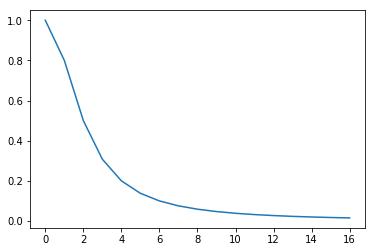

In [84]:
r=2
hm_size=17

def f(x,r):
    return min(1/(1+(x/r)**2),1)

x=np.arange(0,hm_size,1)
y=[f(t,r) for t in x]
plt.plot(x,y)
print(min(y))

In [24]:
def resize_heatmap(heatmaps,new_size):
    '''
    stretches heatmaps (height,width,channels) to a new size (x,y)
    slow...
    '''
    resized_heatmap=np.zeros((new_size[0],new_size[1],heatmaps.shape[2]))
    scale=np.array(new_size)/np.array(heatmaps.shape[:2])
    for x in range(new_size[0]):
        for y in range(new_size[1]):
            scaled=(np.array([x,y])/scale).astype("int")
            resized_heatmap[x,y,:]=heatmaps[scaled[0],scaled[1],:]
    return resized_heatmap

In [56]:
def apply_heatmaps(image,heatmaps):
    '''
    shows image and it's heatmaps
    @params:
        image:PIL.Image
        heatmaps: Manta Heatmaps list
    '''
    heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
 
    image_size=np.array(image).shape[:2]
    #resize the heatmap to size of image
    #image = image.resize(image_size, Image.ANTIALIAS)
    heatmaps=resize_heatmap(heatmaps,image_size)
    
    #convert to channels-first
    heatmaps=np.moveaxis(heatmaps,-1,0)
    if str(type(image))=="<class 'PIL.Image.Image'>":
        #print("pillow")
        img=np.array(image)
        img= img/255
    else:
        #print("numpy")
        img=image
        

    base_mask=np.zeros_like(heatmaps[0])
    #summarise all heatmaps into one
    
    base_mask=heatmaps.sum(axis=0)
    #we want RED heatmap, so we have to add zero channels for Green and blue
    base_mask=base_mask.reshape(base_mask.shape[0],base_mask.shape[1],1)
    green=np.zeros_like(base_mask)
    blue=np.zeros_like(base_mask)
    mask=np.append(base_mask,green,axis=2)
    mask=np.append(mask,blue,axis=2)

    newpic=(base_mask<0.01)*img + (base_mask>=0.01)*(img*(1-base_mask) + mask)
    plt.imshow(newpic)
    #add anotations
    for i,heatmap in zip(range(len(heatmaps)),heatmaps):
        label=heatmap_order[i]
        #find center of heatmap
        if heatmap.sum()>0:
            center=ndimage.measurements.center_of_mass(heatmap)
            #center=np.argmax(heatmap)
            x=center[0]#center//heatmap.shape[0]
            y=center[1]#center%heatmap.shape[1]      
            plt.annotate(label,xy=(y+5,x))

C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0002 Theola\2-F-20160608-0800-LEI-AsiaArmstrong-THEOLA-Biopsy 37.json
{'height_width': [3456, 4608], 'BLM': [('left-eye', array([ 736, 1457]), 24.0), ('right-eye', array([1145, 2725]), 133.0), ('right-wing', array([2149, 3357]), 23.0), ('tail', array([2981,  852]), 79.0), ('left-gill', array([1904, 1125]), 9.0), ('right-gill', array([1978, 2191]), 64.0)]}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


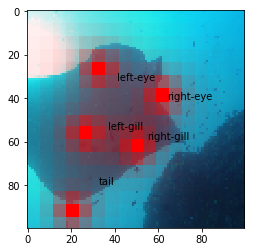

In [87]:
pic_to_show=10

image_path=df.image_path[pic_to_show]
jpath=df.body_landmark_path[pic_to_show]
#jpath="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some\\0012 Laverna\\12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json"
print(jpath)
json_info = extract_body_landmarks(jpath)
print(json_info)
heatmaps=gen_heatmaps(json_info,(17,17))
from PIL import Image
image = Image.open(image_path)
image=image.resize((100,100))
apply_heatmaps(image,heatmaps)
#plt.imshow(image)

In [27]:
def normalize(imag):
        image=np.array(imag)
        image = image[..., ::-1]
        image = image.astype('float')

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68
        return image
    
def denormalize(imag):
        image=copy.deepcopy(imag)
        image[..., 0] += 103.939
        image[..., 1] += 116.779
        image[..., 2] += 123.68
        image = image[..., ::-1]
        return image/255 
    
def image_to_numpy(image,image_size):
    imag = image.resize(image_size, Image.ANTIALIAS)
    imag=normalize(imag)
    return imag

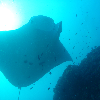

In [29]:
image

In [30]:
npim=image_to_numpy(image,(100,100))

In [31]:
den=denormalize(npim)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


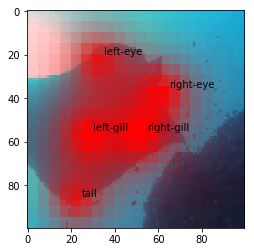

In [32]:
apply_heatmaps(den,heatmaps)

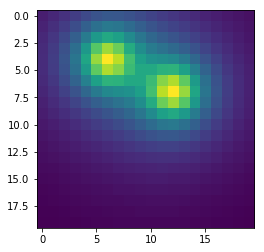

In [49]:
h=heatmaps[:,:,0:2]
plt.imshow(h.sum(axis=2))

In [50]:
from scipy import ndimage
ndimage.measurements.center_of_mass(h.sum(axis=2))

(6.868546316872943, 9.255281742731226)

In [51]:
center=np.argmax(h.sum(axis=2))
x=center//h.shape[0]
y=center%h.shape[1]  

print(x,y)

4 6
